<h1>Process & ML TIME</h1>

Process info from Monmouth University 2020 national poll

In [478]:
import os 
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
import os
import numpy as np
import pandas as pd

from utils import * 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, auc, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np 
import os 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor, XGBClassifier

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

In [479]:
# propensity= pd.read_csv("../data/output11.csv")
# propensity= pd.read_csv("../data/new_prop_scores-2.csv")
# propensity = pd.read_csv("../data/new_prop_scores3.csv")
# propensity = pd.read_csv("../data/new_prop_scores_h2.csv")
propensity = pd.read_csv("../data/new_prop_scores_all.csv")
# propensity = pd.read_csv("../data/new_prop_scores_h3.csv")



<h2>Rename Columns</h2>

In [480]:
def recodeCols(df):

    cols = df.columns
    # vote choice
    if '12_2' not in cols:
        # for march 2020 data
        df['vote_choice_recoded'] = df.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
        df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))
    else:
        # for june 2020 data
        df['vote_choice'] = df.apply(lambda s: np.where(pd.isnull(s['12_1']), s['12_2'], s['12_1']), axis = 1)
      
        df['vote_choice_recoded'] = df.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
        df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 4.0, 9.0], 3.0, s))
    # party recode
    df['party_recoded'] = df.apply(lambda s: np.where(s['party'] in [4.0, 9.0], s['party_unaffiliated'], s['party']), axis = 1)
    df['party_recoded'] = df['party_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

    # age recode
    df['age_recoded'] = df.apply(lambda s: np.where(not pd.isnull(s['age_bin']), s['age_bin'], s['age']), axis = 1)

    df['age_recoded'] = df['age_recoded'].apply(lambda s: np.where(s >= 18 and s <= 34 and not pd.isnull(s), 1.0, np.where(s >= 35 and s <= 54, 2.0, 3.0)))   

    # approval ratings 
    df['approve_trump'] = df['approve_trump'] == 1
    df['approve_biden'] = df['approve_biden'] == 1 

    # race, overwrite if hispanic/latino
    df['latino'] = df['latino'] == 1

    def recode_race(s):
        if s['latino'] == 1 or s['race'] == 4: 
            return 4
        elif s['race'] != 5 and s['race'] != 9:
            return s['race']
        else:
            return 9
    df['race_recoded'] = df.apply(recode_race, axis = 1)

    # gender => male = True, female = False
    df['male'] = df['gender'] == 1

    # registered to vote

    df['registered_vote'] = df['registered_vote'] == 1


    # True if they think Trump is focused on important issues, False otherwise
    if 'focused_imp_issues' in cols:
        df['focused_imp_issues'] = df['focused_imp_issues'] == 1

    # combine some of the similar household concern categories 
    if 'top_household_concern' in cols:
        df['top_household_concern'] = df['top_household_concern'].apply(lambda s: np.where(s in [6.0, 7.0], 6.0, s))
        df['top_household_concern'] = df['top_household_concern'].apply(lambda s: np.where(s in [10.0, 11.0], 10.0, s))

    # turn into 1 = no college, 3 = college
    def recode_education(s):
        if s <= 3:
            return 1
        else:
            return 3
    df['education_recoded'] = df['education'].apply(recode_education)
    # combine into liberal, conservative, moderate, or other
    def recode_political_leaning(s):
        if s <= 2:
            return 1
        elif s == 4 or s == 9:
            return 2
        elif s == 3:
            return 3
        else:
            return 4
    df['political_leaning'] = df['political_leaning'].apply(recode_political_leaning)

    # Do you feel optimistic or pessimistic about the 2020 presidential election? 1 or 2 = optimistic of some sort, else pessimistic of some sort
    df['optimistic'] = df['optimistic'] <= 2

    # confidence in trump stamina to be president, under 2 is confident, over 2 is not confident
    if 'trump_stamina' in cols:
        df['trump_stamina'] = df['trump_stamina'] <= 2
    # confidence in biden stamina to be president, under 2 is confident, over 2 is not confident
    if 'biden_stamina' in cols:
        df['biden_stamina'] = df['biden_stamina'] <= 2
    ### https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
    def recode_region(s):
        new_england = [9.0, 23.0, 25.0, 33.0, 44.0, 50.0, 34.0, 36.0, 42.0]
        midwest = [18.0, 17.0, 26.0, 39.0, 55.0, 19.0, 20.0, 27.0, 29.0, 31.0, 38.0, 46.0]
        south = [10.0, 11.0, 12.0, 13.0, 24.0, 37.0, 45.0, 51.0, 54.0, 1.0, 21.0, 28.0, 47.0, 5.0, 22.0, 40.0, 48.0]
        west = [4.0, 8.0, 16.0, 35.0, 30.0, 49.0, 32.0, 56.0, 2.0, 6.0, 15.0, 41.0, 53.0]
        
        if s in new_england:
            return 1
        elif s in midwest:
            return 2 
        elif s in south:
            return 3
        elif s in west:
            return 4
        
    df['region'] = df['state'].apply(recode_region)

    # merge propensities
    df['age_recoded'] = df['age_recoded'].astype(int)
    df_result = pd.merge(df, propensity, 
                        on=['male', 'race_recoded', 'education_recoded', 'age_recoded', 'STATEFIP'], 
                        how='left')

    # Renaming the merged column for clarity
    df['propensity'] = df_result['mrp_subgroup_estimate']
    df = df.dropna(subset = ['vote_choice_recoded'], how = 'all')

    return df

In [481]:
nat_2020 = pd.read_csv("../data/national_march_2020/MUP213_NATL_archive.tab", sep = "\t")
nat_2020 = nat_2020.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12B': 'vote_choice_undecided', 
        'Q13': 'approve_trump',
        'Q14': 'approve_biden',
        'Q15': 'optimistic',
        'Q16': 'elec_enthusiasm',
        'Q17': 'economic_situation',
        'Q19': 'focused_imp_issues',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})

nat_2020 = nat_2020.drop(columns = [c for c in nat_2020.columns if 'Q' in c])
nat_2020['STATEFIP'] = nat_2020['state']
nat_2020 = recodeCols(nat_2020)
third_party_mar = nat_2020[nat_2020['vote_choice_recoded'] == 3.0]

nat_2020_pre_dummies = nat_2020.copy()


In [482]:
nat_2020_june = pd.read_csv("../data/national_june_2020/MUP218_NATL_archive_full.tab", sep = "\t")
nat_2020_june = nat_2020_june.rename(columns = {
        # 'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12_1': '12_1',
        'Q12_2': '12_2',
        'Q12B': 'vote_choice_undecided', 
        'Q15': 'approve_trump',
        'Q16': 'approve_biden',
        'Q19': 'optimistic',
        'Q21': 'elec_enthusiasm',
        'Q3': 'economic_situation',
        # 'Q19': 'focused_imp_issues',
        'Q17': 'trump_stamina',
        'Q18': 'biden_stamina',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020_june = nat_2020_june.drop(columns = [c for c in nat_2020_june.columns if 'Q' in c])
nat_2020_june['STATEFIP'] = nat_2020_june['state']
nat_2020_june = recodeCols(nat_2020_june)
nat_2020_june.drop(columns=['12_1', '12_2', 'vote_choice', 'vote_choice_undecided'], inplace = True)
third_party_june = nat_2020_june[nat_2020_june['vote_choice_recoded'] == 3.0]


In [483]:
nat_2020_aug = pd.read_csv("../data/national_aug_2020/MUP222_NATL_archive_full.tab", sep = "\t")
nat_2020_aug = nat_2020_aug.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q13': 'likely_to_vote', 
        'Q14': 'vote_choice', 
        # 'Q14_1': '14_1',
        # 'Q14_2': '14_2',
        'Q14B': 'vote_choice_undecided', 
        'Q17': 'approve_trump',
        'Q18': 'approve_biden',
        'Q21': 'optimistic',
        'Q23': 'elec_enthusiasm',
        # 'Q3': 'economic_situation',
        # 'Q19': 'focused_imp_issues',
        # 'Q17': 'trump_stamina',
        # 'Q18': 'biden_stamina',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020_aug = nat_2020_aug.drop(columns = [c for c in nat_2020_aug.columns if 'Q' in c])
nat_2020_aug['STATEFIP'] = nat_2020_aug['state']

nat_2020_aug = recodeCols(nat_2020_aug)

nat_2020_aug.columns
nat_2020_aug.drop(columns=['vote_choice', 'vote_choice_undecided'], inplace = True)

<h2>Add Dummy Variables</h2>

In [761]:
categoricals = ['registered_vote', 'region','economic_situation','likely_to_vote', 'education_recoded','elec_enthusiasm', 'political_leaning', 'race_recoded', 'party_recoded', 'age_recoded']
june_categoricals = ['registered_vote', 'region','economic_situation','likely_to_vote',  'education_recoded','elec_enthusiasm', 'political_leaning','race_recoded', 'party_recoded', 'age_recoded']
aug_categoricals = ['registered_vote', 'region','top_household_concern','likely_to_vote',  'education_recoded','elec_enthusiasm', 'political_leaning','race_recoded', 'party_recoded', 'age_recoded']

In [762]:
def dummyGrabber(df, cats):
    for category in cats:
        df[category] = df[category].astype('category')
    dummies = pd.get_dummies(df[cats])
    df = df[[c for c in df.columns if c not in cats]]
        
    df = pd.concat([df, dummies], axis = 1)
    
    return df

In [763]:
def checkVoteRecode(df):
    df = df[df['vote_choice_recoded'] != 3.0]
    # change trump to be 1 and biden to be 0
    # biden originally encoded as 2 and trump as 1. 
    # drop if vote choice recorded is null
    df = df.dropna(subset = ['vote_choice_recoded'])
    # vote choice recoded to int
    df['vote_choice_recoded'] = df['vote_choice_recoded'].astype(int)
    df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))


    return df

In [764]:
nat_2020_june = checkVoteRecode(nat_2020_june)
nat_2020_aug = checkVoteRecode(nat_2020_aug)
nat_2020 = checkVoteRecode(nat_2020)

In [765]:
march_dummies = dummyGrabber(nat_2020, categoricals)
nat_2020_clean = march_dummies.drop(columns = ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education',])
nat_2020_clean
nat_2020_clean2= nat_2020_clean.drop(columns=['FINALWGT', 'vote_choice', 'vote_choice_undecided','state'])
# nat_2020_clean2= nat_2020_clean.drop(columns=[ 'vote_choice', 'vote_choice_undecided','state'])
nat_2020_clean2.columns

Index(['top_household_concern', 'approve_trump', 'approve_biden', 'optimistic',
       'focused_imp_issues', 'STATEFIP', 'vote_choice_recoded', 'male',
       'propensity', 'registered_vote_True', 'region_1.0', 'region_2.0',
       'region_3.0', 'region_4.0', 'economic_situation_1',
       'economic_situation_2', 'economic_situation_3', 'economic_situation_9',
       'likely_to_vote_1.0', 'likely_to_vote_2.0', 'likely_to_vote_3.0',
       'likely_to_vote_4.0', 'education_recoded_1', 'education_recoded_3',
       'elec_enthusiasm_1', 'elec_enthusiasm_2', 'elec_enthusiasm_3',
       'elec_enthusiasm_9', 'political_leaning_1', 'political_leaning_2',
       'political_leaning_3', 'political_leaning_4', 'race_recoded_1',
       'race_recoded_2', 'race_recoded_3', 'race_recoded_4', 'race_recoded_9',
       'party_recoded_1.0', 'party_recoded_2.0', 'party_recoded_3.0',
       'age_recoded_1', 'age_recoded_2', 'age_recoded_3'],
      dtype='object')

In [767]:
june_dummies = dummyGrabber(nat_2020_june, june_categoricals)
nat_2020_june_clean = june_dummies.drop(columns = ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education',])
nat_2020_june_clean
nat_2020_june_clean2 = nat_2020_june_clean.drop(columns=['FINALWGT', 'state'])
# nat_2020_june_clean2 = nat_2020_june_clean.drop(columns=[ 'state'])

In [490]:
aug_dummies = dummyGrabber(nat_2020_aug, aug_categoricals)
nat_2020_aug_clean = aug_dummies.drop(columns = ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education',])
nat_2020_aug_clean
nat_2020_aug_clean2 = nat_2020_aug_clean.drop(columns=['FINALWGT', 'state'])
# nat_2020_aug_clean2 = nat_2020_aug_clean.drop(columns=[ 'state'])

# MACHINE LEARNING SETUP

In [748]:
models = [
  

    # ("Logistic Regression Classification", LogisticRegression(), {'C': [1, 2]}),
    # 'model__n_estimators': [75, 100, 150,200, 250, 350, 400], 'model__max_depth':[ 3, 4, 5, 6], 'model__min_samples_split': [3, 4, 5], 'model__min_weight_fraction_leaf':[0, 0.001],'model__max_features': ['sqrt', 'log2', 0.8], 'model__random_state': [13]

    # {'model__n_estimators': [100, 150,200, 300, 450, 500], 'model__max_depth': [3, 5, 4, 6,7], 'model__learning_rate': [0.01, 0.025, .05, 0.75, 0.1], 'model__max_features': ['sqrt', 'log2', 0.8], 'model__random_state': [13]}
    ("Random Forest Classification", RandomForestClassifier(),{'n_estimators': [75, 100, 150,200, 250, 350, 400], 'max_depth':[ 3, 4, 5, 6], 'min_samples_split': [3, 4, 5, 6],'max_features': ['sqrt', 'log2', 0.8], 'random_state': [13]}),
    # ("Random Forest Classification2", RandomForestClassifier(min_samples_split = 3,  n_estimators=75), {'model__n_estimators': [75, 100, 150,200, 250, 350, 400], 'model__max_depth':[ 3, 4, 5, 6], 'model__min_samples_split': [3, 4, 5], 'model__min_weight_fraction_leaf':[0, 0.001],'model__max_features': ['sqrt', 'log2', 0.8], 'model__random_state': [13]}), 
    ('Gradient Boosting Classification', GradientBoostingClassifier(), {'n_estimators': [100, 150,200, 300, 450], 'max_depth': [3, 5, 4, 6,7], 'learning_rate': [0.01, 0.025, .05, 0.75, 0.1], 'max_features': ['sqrt', 'log2', 0.8], 'random_state': [13]}),
    # ("Gradient Boosting Classification", GradientBoostingClassifier(criterion='squared_error', n_estimators=440, max_depth=5, learning_rate=0.012, random_state=0, max_features='sqrt'), {'n_estimators': [50, 100,150,200]}),
    # ("Gradient Boosting Classification2", GradientBoostingClassifier(criterion='squared_error', n_estimators=100, max_depth=7, learning_rate=0.2, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200, 300]}),
    # ("Gradient Boosting Classification3", GradientBoostingClassifier( n_estimators=375, max_depth=3, learning_rate=0.02, random_state=0, max_features=2), {'n_estimators': [100,150,200, 400], 'max_depth': [3, 5, 7]}),
]

In [752]:
def modelFunc(X_train, y_train, X_test, y_test, data_dummies, models):
    best_f1 = 0
    for model in models:
    
        name = model[0]
        print(model[0])
        clf = model[1]
        params = model[2]

        # numeric_cols = ['propensity', 'FINALWGT']

       
        


        # preprocessor = ColumnTransformer(
        #     transformers=[
        #         ("num", StandardScaler(), numeric_cols),

        #     ]
        # )
        # pipe = Pipeline(steps=[ ('model', clf)])
      
        grids =  GridSearchCV(clf, param_grid=params, scoring=['f1_weighted', 'neg_root_mean_squared_error'],cv=3, n_jobs=-1, refit='f1_weighted')
        grids.fit(X_train, y_train)
        y_preds = grids.best_estimator_.predict(X_test)
        if f1_score(y_test, y_preds, average='weighted') >= best_f1:
            new_model = grids.best_estimator_
            best_f1 = f1_score(y_test, y_preds, average='weighted')
        # result = cross_validate(grids.best_estimator_, X_train, y_train, cv=5, scoring='f1_weighted')
        # result = cross_validate(grids.best_estimator_, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3)
   
        # print('train result rmse', result['test_score'])
        # print('mean_score rmse:', -np.mean(result['test_score']))
        # test_result = cross_validate(grids.best_estimator_, X_test, y_test, scoring='neg_root_mean_squared_error')
        # print(test_result)
        
        # print('test result rmse:', test_result['test_score'])
        # print('mean score rmse:', -np.mean(test_result['test_score']))

        print(classification_report(y_test, y_preds))
        
     
        # y_preds = grids.best_estimator_.predict(X_test)


        print('f1', f1_score(y_test, y_preds, average='weighted'))
    print('best model', new_model, 'model params', new_model.get_params())
    new_model.fit(X_train, y_train)


    features=X_train.columns
    importances = new_model.feature_importances_
    indices = np.argsort(importances)

    # plt.figure(1)
    # plt.title('Feature Importances')
    # plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    # plt.yticks(range(len(indices)), features[indices])
    # plt.xlabel('Relative Importance')
    feat_importances = pd.Series(new_model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(15).plot(kind='barh')

    y_preds = new_model.predict(X_test)
    y_preds = new_model.predict_proba(X_test)
    y_preds = [x[1] for x in y_preds]
    X_test_copy = X_test.copy()
    X_test_copy['predicted_vote'] = y_preds
    X_test_copy['actual_vote'] = y_test
    X_test_copy_filtered = X_test_copy[['approve_trump', 'approve_biden', 'optimistic','male',  'race_recoded_1', 'race_recoded_2', 'race_recoded_3', 'race_recoded_4',
       'race_recoded_9', 'party_recoded_1.0',
       'party_recoded_2.0', 'age_recoded_1', 'age_recoded_2', 'age_recoded_3', 'predicted_vote','actual_vote', 'education_recoded_3', 'education_recoded_1']]

    filtered_nat_df = data_dummies.loc[X_test_copy_filtered.index].drop(columns= ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'vote_choice_recoded', 'state'])
    filtered_nat_df['predicted_vote'] = X_test_copy['predicted_vote']
    filtered_nat_df['actual_vote'] = X_test_copy['actual_vote']
    
    df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'], )['predicted_vote'].value_counts().unstack(fill_value=0)

    # probability version
    df_final_pred2 = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].mean()
    #filtered_nat_2020.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)
    return df_final_pred2, new_model

Random Forest Classification
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       188
           1       0.93      0.92      0.93       169

    accuracy                           0.93       357
   macro avg       0.93      0.93      0.93       357
weighted avg       0.93      0.93      0.93       357

f1 0.9327508781290293
Gradient Boosting Classification
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       188
           1       0.93      0.92      0.92       169

    accuracy                           0.93       357
   macro avg       0.93      0.93      0.93       357
weighted avg       0.93      0.93      0.93       357

f1 0.9271467846397818
best model RandomForestClassifier(max_depth=6, max_features='log2', min_samples_split=4,
                       n_estimators=150, random_state=13) model params {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini',

<Axes: >

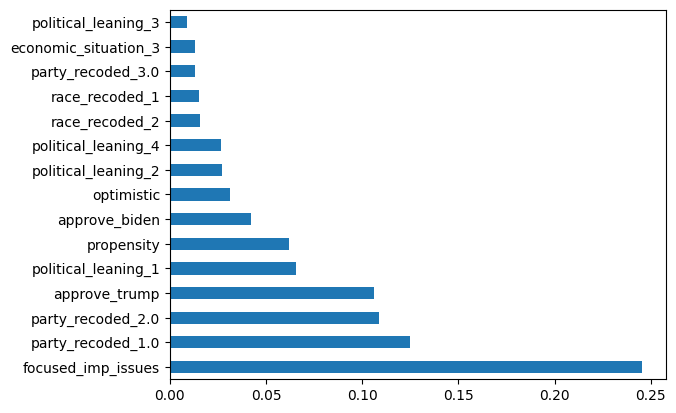

In [768]:
nat_2020_clean2 = nat_2020_clean2.dropna()
X = nat_2020_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP', 'top_household_concern'])
y = nat_2020_clean2['vote_choice_recoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 13)
mar_pred, new_model_mar = modelFunc(X_train, y_train, X_test, y_test, nat_2020_pre_dummies, models)
features=X_train.columns
importances = new_model_mar.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(new_model_mar.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

<Axes: >

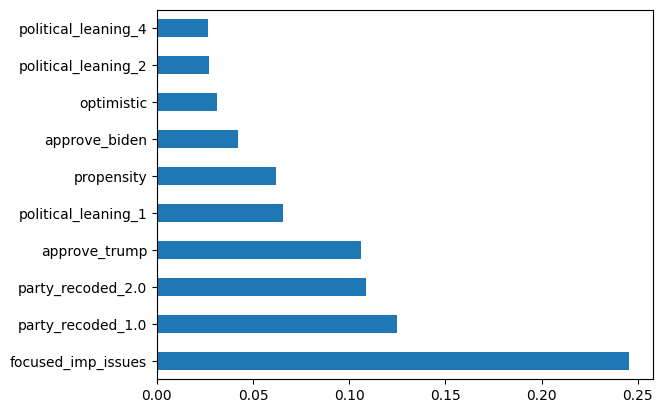

In [769]:
features=X_train.columns
importances = new_model_mar.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(new_model_mar.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

<Axes: title={'center': 'Machine Learning Model Feature Importances'}, xlabel='Feature Importances', ylabel='Poll Questions'>

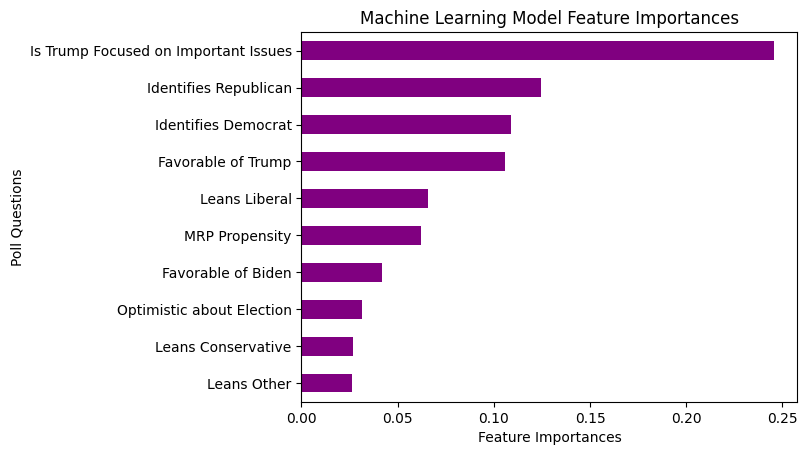

In [796]:
feat_importances.nlargest(10).to_dict()

importances = {'Is Trump Focused on Important Issues': 0.24551637087202546,
 'Identifies Republican': 0.12466693943532543,
 'Identifies Democrat': 0.10894603472895334,
 'Favorable of Trump': 0.10586249291368698,
 'Leans Liberal': 0.0656888460601003,
 'MRP Propensity': 0.06190145440541663,
 'Favorable of Biden': 0.04195795725784075,
 'Optimistic about Election': 0.03136094290446979,
 'Leans Conservative': 0.02699039444792767,
 'Leans Other': 0.02642526434093232}
# make bar plot of importances
import matplotlib.pyplot as plt
# plt.bar(importances.values(), importances.keys())
# convert importances to a series
# sort importances to be in descending order
importances_s = pd.Series(importances.values(), importances.keys())
# sort importances
importances_s = importances_s.sort_values(ascending=True)
# make bar plot of importances
# importances.plot(kind='bar')

# importances_s = pd.Series(importances.values(), importances.keys())
# sort importances
# importances = importances.sort_values(ascending=False)
# make bar plot of importances
# importances.plot(kind='bar')
importances_s.plot(kind='barh', color='purple', title='Machine Learning Model Feature Importances', xlabel='Feature Importances', ylabel='Poll Questions')


In [795]:
importances_s

Is Trump Focused on Important Issues   0.2455
Identifies Republican                  0.1247
Identifies Democrat                    0.1089
Favorable of Trump                     0.1059
Leans Liberal                          0.0657
MRP Propensity                         0.0619
Favorable of Biden                     0.0420
Optimistic about Election              0.0314
Leans Conservative                     0.0270
Leans Other                            0.0264
dtype: float64

Is Trump Focused on Important Issues   0.2455
Identifies Republican                  0.1247
Identifies Democrat                    0.1089
Favorable of Trump                     0.1059
Leans Liberal                          0.0657
MRP Propensity                         0.0619
Favorable of Biden                     0.0420
Optimistic about Election              0.0314
Leans Conservative                     0.0270
Leans Other                            0.0264
dtype: float64

Random Forest Classification
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       204
           1       0.96      0.90      0.93       143

    accuracy                           0.95       347
   macro avg       0.95      0.94      0.94       347
weighted avg       0.95      0.95      0.94       347

f1 0.9449463161708795
Gradient Boosting Classification
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       204
           1       0.96      0.89      0.92       143

    accuracy                           0.94       347
   macro avg       0.94      0.93      0.94       347
weighted avg       0.94      0.94      0.94       347

f1 0.9390652920016782
best model RandomForestClassifier(max_depth=3, max_features='log2', min_samples_split=3,
                       n_estimators=250, random_state=13) model params {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini',

/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12945/3972502643.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'], )['predicted_vote'].value_counts().unstack(fill_value=0)
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12945/3972502643.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred2 = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].mean()


<Axes: >

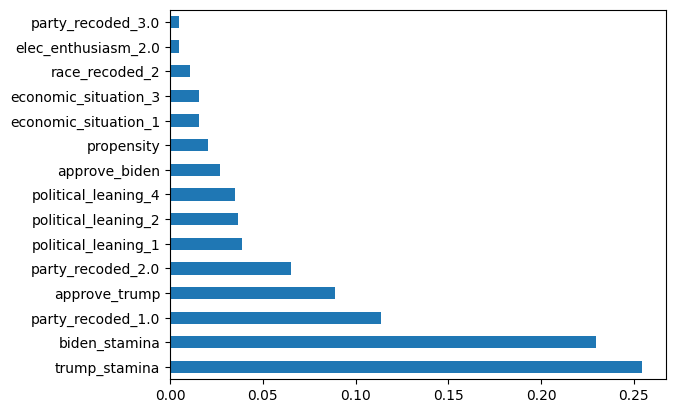

In [754]:
nat_2020_june_clean2.dropna(subset = ['STATEFIP'], how = 'all', inplace = True)
nat_2020_june_clean2 = nat_2020_june_clean2.dropna()
X = nat_2020_june_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
y = nat_2020_june_clean2['vote_choice_recoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 13)
june_pred, new_model_june = modelFunc(X_train, y_train, X_test, y_test, nat_2020_june, models)
features=X_train.columns
importances = new_model_june.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(new_model_june.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

Random Forest Classification
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       203
           1       0.93      0.86      0.90       160

    accuracy                           0.91       363
   macro avg       0.92      0.91      0.91       363
weighted avg       0.91      0.91      0.91       363

f1 0.9113938113503142
Gradient Boosting Classification
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       203
           1       0.91      0.86      0.88       160

    accuracy                           0.90       363
   macro avg       0.90      0.90      0.90       363
weighted avg       0.90      0.90      0.90       363

f1 0.9004188626622645
best model RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=200,
                       random_state=13) model params {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max

/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12945/3972502643.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'], )['predicted_vote'].value_counts().unstack(fill_value=0)
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12945/3972502643.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred2 = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].mean()


<Axes: >

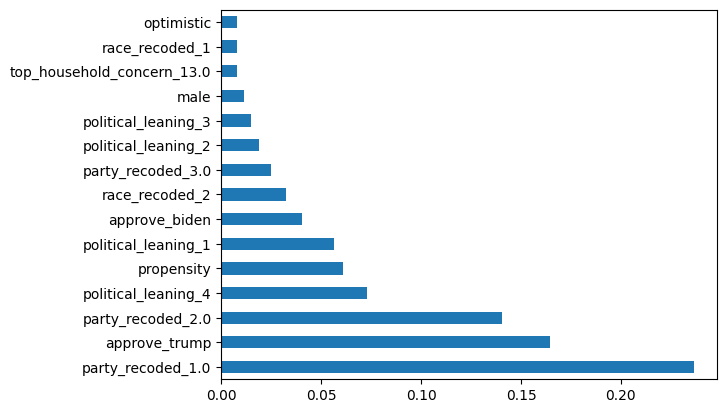

In [755]:
at_2020_aug_clean2 = nat_2020_aug_clean2.dropna()
X = nat_2020_aug_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
y = nat_2020_aug_clean2['vote_choice_recoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 13)
aug_pred, new_model_aug = modelFunc(X_train, y_train, X_test, y_test, nat_2020_aug, models)
features=X_train.columns
importances = new_model_aug.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(new_model_aug.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

Random Forest Classification
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       207
           1       0.94      0.92      0.93       186

    accuracy                           0.93       393
   macro avg       0.93      0.93      0.93       393
weighted avg       0.93      0.93      0.93       393

f1 0.9337992304479632
Gradient Boosting Classification
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       207
           1       0.91      0.92      0.92       186

    accuracy                           0.92       393
   macro avg       0.92      0.92      0.92       393
weighted avg       0.92      0.92      0.92       393

f1 0.9211298338255516
best model RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=350,
                       random_state=13) model params {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max

KeyboardInterrupt: 

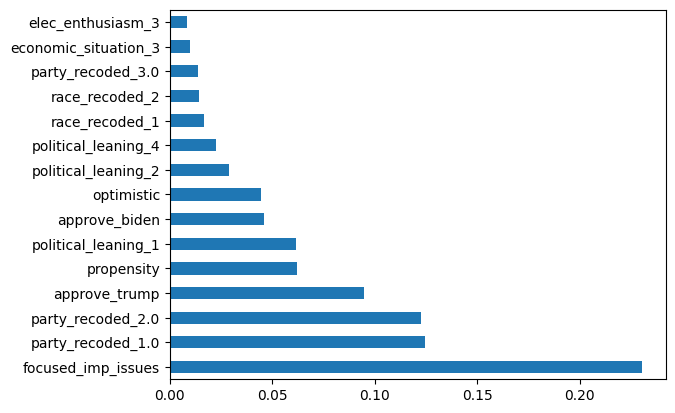

In [750]:
# nat_2020_clean2.notnull().sum()
nat_2020_clean2 = nat_2020_clean2.dropna()
X = nat_2020_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
y = nat_2020_clean2['vote_choice_recoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.55, random_state = 13)
mar_pred = modelFunc(X_train, y_train, X_test, y_test, nat_2020_pre_dummies, models)
nat_2020_june_clean2.dropna(subset = ['STATEFIP'], how = 'all', inplace = True)
nat_2020_june_clean2 = nat_2020_june_clean2.dropna()
X = nat_2020_june_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
y = nat_2020_june_clean2['vote_choice_recoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.55, random_state = 13)
june_pred = modelFunc(X_train, y_train, X_test, y_test, nat_2020_june, models)

nat_2020_aug_clean2 = nat_2020_aug_clean2.dropna()
X = nat_2020_aug_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
y = nat_2020_aug_clean2['vote_choice_recoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.55, random_state = 13)
aug_pred = modelFunc(X_train, y_train, X_test, y_test, nat_2020_aug, models)

In [498]:
nat_2020_june_clean2.dropna(subset = ['STATEFIP'], how = 'all', inplace = True)
nat_2020_june_clean2 = nat_2020_june_clean2.dropna()
X = nat_2020_june_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
y = nat_2020_june_clean2['vote_choice_recoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.55, random_state = 13)
june_pred = modelFunc(X_train, y_train, X_test, y_test, nat_2020_june, models)

Random Forest Classification
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       225
           1       0.96      0.92      0.94       157

    accuracy                           0.95       382
   macro avg       0.95      0.95      0.95       382
weighted avg       0.95      0.95      0.95       382

f1 0.9527306187887615
Gradient Boosting Classification
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       225
           1       0.95      0.93      0.94       157

    accuracy                           0.95       382
   macro avg       0.95      0.95      0.95       382
weighted avg       0.95      0.95      0.95       382

f1 0.9527831573872434
best model Pipeline(steps=[('model',
                 GradientBoostingClassifier(learning_rate=0.75, max_depth=6,
                                            max_features='sqrt',
                                            random_state=13))

/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12945/1106038495.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'], )['predicted_vote'].value_counts().unstack(fill_value=0)
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12945/1106038495.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred2 = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].mean()


In [499]:
june_pred

age_recoded  race_recoded  male   education_recoded
1            1             False  1                    3.333622e-01
                                  3                    3.322514e-01
                           True   1                    5.575970e-01
                                  3                    3.906645e-01
             2             False  1                    1.936743e-09
                                  3                    8.337713e-07
                           True   1                    5.006593e-01
                                  3                    1.390682e-05
             3             False  1                             NaN
                                  3                    1.826803e-11
                           True   1                             NaN
                                  3                    2.043868e-06
             4             False  1                             NaN
                                  3                    2.500037e

In [495]:
all_genders = [True, False ]
all_ages = [1,2, 3]
all_educations = [1,3]
all_races = [1,2, 3,4,9]
all_combinations = pd.MultiIndex.from_product([all_ages,all_races, all_genders, all_educations], names=['age_recoded','race_recoded', 'male','education_recoded']).to_frame(index=False)
mar_pred = pd.merge(all_combinations,mar_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
june_pred= pd.merge(all_combinations,june_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')

merge_mar_june = pd.merge(mar_pred, june_pred, on=['age_recoded',	'race_recoded',	'male', 'education_recoded'], how='outer').fillna(0)

aug_pred = pd.merge(all_combinations,aug_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
# merge_mar_june['0'] = merge_mar_june['0_x'] + merge_mar_june['0_y']
# # add 1_x and 1_y together
# merge_mar_june['1'] = merge_mar_june['1_x'] + merge_mar_june['1_y']
# # drop the _x and _y columns
# merge_mar_june = merge_mar_june.drop(columns = ['0_x', '0_y', '1_x', '1_y'])

# # add the propensity vibe column
# merge_mar_june['propensity_t_pred'] = merge_mar_june['1'] / (merge_mar_june['0'] + merge_mar_june['1'])

merge_mar_june['pred'] = (merge_mar_june['predicted_vote_x'] + merge_mar_june['predicted_vote_y']) / 2
# merge_mar_june

/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12945/3403184660.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merge_mar_june = pd.merge(mar_pred, june_pred, on=['age_recoded',	'race_recoded',	'male', 'education_recoded'], how='outer').fillna(0)


In [500]:
# Set the float display option
pd.options.display.float_format = '{:.4f}'.format

In [501]:
merge_mar_june

,age_recoded,race_recoded,male,education_recoded,predicted_vote_x,predicted_vote_y,pred
0,1,1,False,1,0.7176,0.3334,0.5255
1,1,1,False,3,0.3327,0.3323,0.3325
2,1,1,True,1,0.4932,0.5576,0.5254
3,1,1,True,3,0.4079,0.3907,0.3993
4,1,2,False,1,0.0000,0.0000,0.0000
5,1,2,False,3,0.0699,0.0000,0.0349
6,1,2,True,1,0.0000,0.5007,0.2503
7,1,2,True,3,0.0787,0.0000,0.0394
8,1,3,False,1,0.0000,0.0000,0.0000
9,1,3,False,3,0.0677,0.0000,0.0338


In [425]:
aug_pred = pd.merge(all_combinations,aug_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
aug_pred
aug_pred['0_aug'] = aug_pred[0]
aug_pred['1_aug'] = aug_pred[1]
aug_pred.drop(columns = [0, 1], inplace = True)
aug_pred

,age_recoded,race_recoded,male,education_recoded,0_aug,1_aug
0,1,1,False,1,0,0
1,1,1,False,3,11,6
2,1,1,True,1,2,6
3,1,1,True,3,11,6
4,1,2,False,1,0,0
5,1,2,False,3,8,0
6,1,2,True,1,1,0
7,1,2,True,3,4,0
8,1,3,False,1,0,0
9,1,3,False,3,2,0


In [456]:
aug_pred

age_recoded  race_recoded  male   education_recoded
1            1             False  1                         NaN
                                  3                    0.376896
                           True   1                    0.649248
                                  3                    0.374967
             2             False  1                         NaN
                                  3                    0.087213
                           True   1                    0.213270
                                  3                    0.162680
             3             False  1                         NaN
                                  3                    0.123485
                           True   1                         NaN
                                  3                    0.050870
             4             False  1                         NaN
                                  3                    0.367060
                           True   1                 

In [502]:
aug_pred = pd.merge(all_combinations,aug_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
merge_mar_june_aug = pd.merge(merge_mar_june, aug_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer').fillna(0)
# merge_mar_june_aug['0'] = merge_mar_june_aug['0'] + merge_mar_june_aug['0_aug']
# merge_mar_june_aug['1'] = merge_mar_june_aug['1'] + merge_mar_june_aug['1_aug']
# merge_mar_june_aug = merge_mar_june_aug.drop(columns = ['0_aug', '1_aug'])
# merge_mar_june_aug['propensity_t_pred'] = merge_mar_june_aug['1'] / (merge_mar_june_aug['0'] + merge_mar_june_aug['1'])
merge_mar_june_aug['pred'] = (merge_mar_june_aug['pred'] + merge_mar_june_aug['predicted_vote']) / 2

/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12945/3219750081.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merge_mar_june_aug = pd.merge(merge_mar_june, aug_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer').fillna(0)


In [503]:
merge_mar_june_aug

,age_recoded,race_recoded,male,education_recoded,predicted_vote_x,predicted_vote_y,pred,predicted_vote
0,1,1,False,1,0.7176,0.3334,0.2627,0.0000
1,1,1,False,3,0.3327,0.3323,0.3484,0.3644
2,1,1,True,1,0.4932,0.5576,0.5735,0.6217
3,1,1,True,3,0.4079,0.3907,0.3929,0.3866
4,1,2,False,1,0.0000,0.0000,0.0000,0.0000
5,1,2,False,3,0.0699,0.0000,0.0704,0.1059
6,1,2,True,1,0.0000,0.5007,0.2505,0.2507
7,1,2,True,3,0.0787,0.0000,0.1121,0.1849
8,1,3,False,1,0.0000,0.0000,0.0000,0.0000
9,1,3,False,3,0.0677,0.0000,0.1044,0.1750


In [557]:

merged_df = merge_mar_june_aug.copy()
# merged_df = merge_mar_june
post_strat = pd.read_csv("../data/post_stratification_data_by_state.csv")
# propensity = pd.read_csv("../data/output11.csv")
# propensity= pd.read_csv("../data/new_prop_scores-2.csv")
# propensity = pd.read_csv("../data/new_prop_scores3.csv")
# propensity = pd.read_csv("../data/new_prop_scores_h2.csv")
propensity = pd.read_csv("../data/new_prop_scores_all.csv")
# propensity = pd.read_csv("../data/new_prop_scores_h3.csv")


megaStrat = pd.merge(propensity, post_strat, how='left', on=['STATEFIP',	'age_recoded',	'race_recoded'	,'male'	,'education_recoded'])
# megaStrat = pd.merge(propensity, post_strat, how='left', on=[	'age_recoded',	'race_recoded'	,'male'	,'education_recoded'])
megaStrat = megaStrat.dropna()

In [558]:
# propensity= pd.read_csv("../data/new_prop_scores-2.csv")
# propensity = pd.read_csv("../data/new_prop_scores3.csv")
# propensity = pd.read_csv("../data/new_prop_scores_h2.csv")
propensity = pd.read_csv("../data/new_prop_scores_all.csv")
# propensity = pd.read_csv("../data/new_prop_scores_h3.csv")



propensity['age_recoded'].value_counts()

age_recoded
1    1020
2    1020
3    1020
Name: count, dtype: int64

In [559]:
# propensity = pd.read_csv("../data/output11.csv")
# propensity['age_recoded'].value_counts()

In [560]:
megaStrat

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,prop
0,1,1,1,1,1,0.7247,0.0282,330345.0000,0.0013
1,1,1,1,1,2,0.7270,0.0311,58181.0000,0.0002
2,1,1,1,1,4,0.6596,0.0268,381824.0000,0.0015
3,1,1,1,1,5,0.6943,0.0354,226141.0000,0.0009
4,1,1,1,1,6,0.5028,0.0243,1556291.0000,0.0061
...,...,...,...,...,...,...,...,...,...
3055,3,9,0,3,51,0.3859,0.0402,564.0000,0.0000
3056,3,9,0,3,53,0.2991,0.0343,512.0000,0.0000
3057,3,9,0,3,54,0.4354,0.0447,111.0000,0.0000
3058,3,9,0,3,55,0.3833,0.0381,258.0000,0.0000


In [626]:
# propensity = pd.read_csv("../data/output7.csv") 
# propensity = pd.read_csv("../data/output11.csv")
# propensity = pd.read_csv("../data/new_prop_scores.csv")

# 7 is best so far
# propensity = pd.read_csv("../data/output10.csv")

# post_strat = post_strat.drop(columns = ['prop'])
# # propensity = propensity.drop(columns = ['mrp_subgroup_estimate_se'])
# propensity_strat = pd.merge(propensity, post_strat)
# multiply by 0.595 if male, 0.63 if female
propensity_strat = megaStrat.copy()

propensity_strat['PERWT_scaled'] = propensity_strat.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)



multipliers_age = {
    1: 0.55,
    2: 0.656,
    3: 0.73,
}
# White 69.8, black 58.7, asian 42.8, latino 38.8
# 2018 57.5, 51.4, 40.4, 40.3

multipliers = {
    1: 0.575,
    2: 0.514,
    3: 0.404,
    4: 0.403,
    9: 0.5
}

# make perwt scaled multiplied if its white black asian or latino
propensity_strat['PERWT_scaled_race'] = propensity_strat.apply(lambda row: row['PERWT'] * multipliers[row['race_recoded']], axis=1)

propensity_strat['PERWT_scaled_age'] = propensity_strat.apply(lambda row: row['PERWT'] * multipliers_age[row['age_recoded']], axis=1)

# propensity_strat['PERWT_scaled'] = propensity_strat.apply(
# propensity_strat['PERWT_scaled'] = propensity_strat.apply(
#     lambda row: row['PERWT'] * 0.698 if row['race_recoded'] == 1 elif row['PERWT'] * 0.698 if row['race_recoded'] == 1 else row['PERWT'] * 0.63, axis=1
# )
propensity_strat['trumpVote'] = propensity_strat['mrp_subgroup_estimate'] * propensity_strat['PERWT_scaled']
propensity_strat['bidenVote'] = (1 - propensity_strat['mrp_subgroup_estimate']) * propensity_strat['PERWT_scaled']
propensity_strat
print('trump percent', propensity_strat['trumpVote'].sum() / (propensity_strat['trumpVote'].sum() + propensity_strat['bidenVote'].sum()), 'trumpSum', propensity_strat['trumpVote'].sum())
print('biden percent', propensity_strat['bidenVote'].sum() / (propensity_strat['trumpVote'].sum() + propensity_strat['bidenVote'].sum()), 'bidenSum', propensity_strat['bidenVote'].sum())
propensity_strat

trump percent 0.5045714836390629 trumpSum 78339289.85778867
biden percent 0.49542851636093704 bidenSum 76919761.43221132


,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,prop,PERWT_scaled,PERWT_scaled_race,PERWT_scaled_age,trumpVote,bidenVote
0,1,1,1,1,1,0.7247,0.0282,330345.0000,0.0013,196555.2750,189948.3750,181689.7500,142439.4548,54115.8202
1,1,1,1,1,2,0.7270,0.0311,58181.0000,0.0002,34617.6950,33454.0750,31999.5500,25168.0529,9449.6421
2,1,1,1,1,4,0.6596,0.0268,381824.0000,0.0015,227185.2800,219548.8000,210003.2000,149844.0045,77341.2755
3,1,1,1,1,5,0.6943,0.0354,226141.0000,0.0009,134553.8950,130031.0750,124377.5500,93424.4529,41129.4421
4,1,1,1,1,6,0.5028,0.0243,1556291.0000,0.0061,925993.1450,894867.3250,855960.0500,465577.5673,460415.5777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,3,9,0,3,51,0.3859,0.0402,564.0000,0.0000,355.3200,282.0000,411.7200,137.1037,218.2163
3056,3,9,0,3,53,0.2991,0.0343,512.0000,0.0000,322.5600,256.0000,373.7600,96.4620,226.0980
3057,3,9,0,3,54,0.4354,0.0447,111.0000,0.0000,69.9300,55.5000,81.0300,30.4460,39.4840
3058,3,9,0,3,55,0.3833,0.0381,258.0000,0.0000,162.5400,129.0000,188.3400,62.3067,100.2333


In [627]:
propensity_strat = pd.merge(propensity_strat, merged_df, on = ['age_recoded', 'education_recoded','male', 'race_recoded'], how='left')
# propensity_strat['ML_pred'] = propensity_strat['propensity_t_pred']
propensity_strat['ML_pred'] = propensity_strat['pred']
propensity_strat['ML_pred_mar'] = propensity_strat['predicted_vote_x']
propensity_strat['ML_pred_june'] = propensity_strat['predicted_vote_y']
propensity_strat['ML_pred_aug'] = propensity_strat['predicted_vote']


propensity_strat['ML_pred'] = propensity_strat['ML_pred'].fillna(propensity_strat['mrp_subgroup_estimate'])
propensity_strat['ML_pred_mar'] = propensity_strat['ML_pred_mar'].fillna(propensity_strat['mrp_subgroup_estimate'])
propensity_strat['ML_pred_june'] = propensity_strat['ML_pred_june'].fillna(propensity_strat['mrp_subgroup_estimate'])
propensity_strat['ML_pred_aug'] = propensity_strat['ML_pred_aug'].fillna(propensity_strat['mrp_subgroup_estimate'])


In [645]:
# propensity_strat['ML_pred'] = merged_df['propensity_t_pred'].values
# fill with the originall propensity score if 0
propensity_strat['ML_pred'] = propensity_strat['ML_pred'].fillna(propensity_strat['mrp_subgroup_estimate'])
# if ML pred is 0, fill with MRP pred / 2

propensity_strat.loc[propensity_strat['ML_pred'] == 0, 'ML_pred'] = propensity_strat['mrp_subgroup_estimate'] / 5
propensity_strat.loc[propensity_strat['ML_pred'] == 1, 'ML_pred'] = 1 - (propensity_strat['mrp_subgroup_estimate'] / 8 )
# propensity_strat.loc[propensity_strat['ML_pred'] == 1, 'ML_pred'] = propensity_strat['mrp_subgroup_estimate'] + (propensity_strat['mrp_subgroup_estimate'] / 8 )

#weight the mrp and ml predictions by the PERWT_scaled
propensity_strat['mrp_and_ML'] = ((propensity_strat['mrp_subgroup_estimate'] * 5) + propensity_strat['ML_pred'] + propensity_strat['ML_pred_june']*2) / 8
propensity_strat
propensity_strat['trumpVote_altered'] = propensity_strat['mrp_and_ML'] * propensity_strat['PERWT_scaled']
propensity_strat['bidenVote_altered'] = (1 - propensity_strat['mrp_and_ML']) * propensity_strat['PERWT_scaled']
print('trump sum', propensity_strat['trumpVote_altered'].sum(), 'biden sum', propensity_strat['bidenVote_altered'].sum())
print('trump percent', propensity_strat['trumpVote_altered'].sum() / (propensity_strat['trumpVote_altered'].sum() + propensity_strat['bidenVote_altered'].sum()))
print('biden percent', propensity_strat['bidenVote_altered'].sum() / (propensity_strat['trumpVote_altered'].sum() + propensity_strat['bidenVote_altered'].sum()))


propensity_strat_breakdown = propensity_strat[['male', 'age_recoded','race_recoded', 'education_recoded', 'mrp_subgroup_estimate', 'ML_pred', 'mrp_and_ML', 'ML_pred_mar', 'ML_pred_june', 'ML_pred_aug', 'STATEFIP']]


trump sum 73623199.43388563 biden sum 81635851.85611436
trump percent 0.4741958605451533
biden percent 0.5258041394548467


In [646]:
census_by_state = pd.read_csv("../data/post_stratification_data_by_state.csv")
census_by_state
elec_votes2 = pd.read_csv("../data/2020_electoral_results.csv")
elec_votes = pd.read_csv("../data/2020_ecollege_rep.csv")
elec_votes
# merge the two on stateFIP
census_by_state = pd.merge(census_by_state, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
census_by_state = pd.merge(census_by_state, elec_votes2, left_on = 'state', right_on = 'State')
# White 69.8, black 58.7, asian 42.8, latino 38.8

# multipliers = {
#     1: 0.698,
#     2: 0.587,
#     3: 0.428,
#     4: 0.388,
#     9: 1
# }

# # make perwt scaled multiplied if its white black asian or latino
# census_by_state['PERWT_scaled'] = census_by_state.apply(lambda row: row['PERWT'] * multipliers[row['race_recoded']], axis=1)
census_by_state['PERWT_scaled'] = census_by_state.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)
# map the propensity strat to the census data by education, age, race, gender
census_by_state = pd.merge(census_by_state, propensity_strat_breakdown, on = ['age_recoded', 'education_recoded','male', 'race_recoded', 'STATEFIP' ])
# # census_by_state['mrp_and_ML'] = propensity_strat['mrp_and_ML']
# census_by_state
census_by_state

,STATEFIP,age_recoded,race_recoded,male,education_recoded,PERWT,prop,STATE,STATEFP,STATENS,...,trump,harris,pence,PERWT_scaled,mrp_subgroup_estimate,ML_pred,mrp_and_ML,ML_pred_mar,ML_pred_june,ML_pred_aug
0,1,1,1,False,1,327170.0000,0.0013,AL,1,1779775,...,9,0,9,206117.1000,0.6591,0.2627,0.5281,0.7176,0.3334,0.0000
1,1,1,1,False,3,1916.0000,0.0000,AL,1,1779775,...,9,0,9,1207.0800,0.5687,0.3484,0.4821,0.3327,0.3323,0.3644
2,1,1,1,True,1,330345.0000,0.0013,AL,1,1779775,...,9,0,9,196555.2750,0.7247,0.5735,0.6640,0.4932,0.5576,0.6217
3,1,1,1,True,3,2014.0000,0.0000,AL,1,1779775,...,9,0,9,1198.3300,0.6423,0.3929,0.5482,0.4079,0.3907,0.3866
4,1,1,2,False,1,171855.0000,0.0007,AL,1,1779775,...,9,0,9,108268.6500,0.1647,0.0000,0.1029,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,56,3,4,True,1,4098.0000,0.0000,WY,56,1779807,...,3,0,3,2438.3100,0.6394,0.0210,0.4022,0.0838,0.0000,0.0000
2991,56,3,4,True,3,197.0000,0.0000,WY,56,1779807,...,3,0,3,117.2150,0.5478,0.6655,0.6756,0.5795,1.0000,0.5413
2992,56,3,9,False,1,2080.0000,0.0000,WY,56,1779807,...,3,0,3,1310.4000,0.6270,0.1815,0.4146,0.1070,0.0000,0.3095
2993,56,3,9,False,3,48.0000,0.0000,WY,56,1779807,...,3,0,3,30.2400,0.5191,0.5126,0.5135,0.7227,0.5000,0.4139


In [647]:
turnout_state = pd.read_csv("../data/turnout_by_state.csv")
turnout_state['STATE_NAME'] = turnout_state['State'].str.lower()
census_by_state2 = pd.merge(census_by_state, turnout_state, on = ['STATE_NAME'])
census_by_state2['PERWT_state_scaled'] = census_by_state2['PERWT_scaled'] / 100 * census_by_state2['2020_turnout']

In [648]:
# allStates = pd.read_csv("../data/output11.csv")
# allStates = pd.read_csv("../data/new_prop_scores-2.csv")
# allStates = pd.read_csv("../data/new_prop_scores3.csv")
# allStates = pd.read_csv("../data/new_prop_scores_h2.csv")
allStates = pd.read_csv("../data/new_prop_scores_all.csv")
# allStates = pd.read_csv("../data/new_prop_scores_h3.csv")



elec_votes = pd.read_csv("../data/2020_electoral_results.csv")
elec_votes
# merge the two on stateFIP
allStates = pd.merge(allStates, census_by_state,  on = ['age_recoded', 'education_recoded','male', 'race_recoded', 'STATEFIP'])
# allStates = pd.merge(allStates, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
# census_by_state = pd.merge(census_by_state, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
turnout_state = pd.read_csv("../data/turnout_by_state.csv")
turnout_state['STATE_NAME'] = turnout_state['State'].str.lower()
# allStates['mrp_subgroup_estimate_x'].fillna(allStates['mrp_subgroup_estimate_y'], inplace = True)
# allStates['PERWT_scaled'] = allStates.apply(
#     lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
# )

allStates = pd.merge(allStates, turnout_state, on = ['STATE_NAME'])
allStates['PERWT_state_scaled'] = allStates['PERWT'] * allStates['2020_turnout'] / 100
allStates['PERWT_scaled'] = allStates.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)

multipliers_age = {
    1: 0.55,
    2: 0.656,
    3: 0.73,
}
# White 69.8, black 58.7, asian 42.8, latino 38.8
# 2018 57.5, 51.4, 40.4, 40.3

multipliers = {
    1: 0.575,
    2: 0.514,
    3: 0.404,
    4: 0.403,
    9: 0.5
}

# make perwt scaled multiplied if its white black asian or latino
allStates['PERWT_scaled_race'] = allStates.apply(lambda row: row['PERWT'] * multipliers[row['race_recoded']], axis=1)

allStates['PERWT_scaled_age'] = allStates.apply(lambda row: row['PERWT'] * multipliers_age[row['age_recoded']], axis=1)
allStates

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate_x,mrp_subgroup_estimate_se,PERWT,prop,STATE,...,ML_pred,mrp_and_ML,ML_pred_mar,ML_pred_june,ML_pred_aug,State_y,2020_turnout,PERWT_state_scaled,PERWT_scaled_race,PERWT_scaled_age
0,1,1,1,1,1,0.7247,0.0282,330345.0000,0.0013,AL,...,0.5735,0.6640,0.4932,0.5576,0.6217,Alabama,60.5000,199858.7250,189948.3750,181689.7500
1,1,1,1,1,2,0.7270,0.0311,58181.0000,0.0002,AK,...,0.5735,0.6655,0.4932,0.5576,0.6217,Alaska,63.8000,37119.4780,33454.0750,31999.5500
2,1,1,1,1,4,0.6596,0.0268,381824.0000,0.0015,AZ,...,0.5735,0.6233,0.4932,0.5576,0.6217,Arizona,71.9000,274531.4560,219548.8000,210003.2000
3,1,1,1,1,5,0.6943,0.0354,226141.0000,0.0009,AR,...,0.5735,0.6450,0.4932,0.5576,0.6217,Arkansas,54.0000,122116.1400,130031.0750,124377.5500
4,1,1,1,1,6,0.5028,0.0243,1556291.0000,0.0061,CA,...,0.5735,0.5253,0.4932,0.5576,0.6217,California,65.1000,1013145.4410,894867.3250,855960.0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,3,9,0,3,51,0.3859,0.0402,564.0000,0.0000,VA,...,0.5126,0.4302,0.7227,0.5000,0.4139,Virginia,71.5000,403.2600,282.0000,411.7200
2991,3,9,0,3,53,0.2991,0.0343,512.0000,0.0000,WA,...,0.5126,0.3760,0.7227,0.5000,0.4139,Washington,71.5000,366.0800,256.0000,373.7600
2992,3,9,0,3,54,0.4354,0.0447,111.0000,0.0000,WV,...,0.5126,0.4612,0.7227,0.5000,0.4139,West Virginia,56.1000,62.2710,55.5000,81.0300
2993,3,9,0,3,55,0.3833,0.0381,258.0000,0.0000,WI,...,0.5126,0.4287,0.7227,0.5000,0.4139,Wisconsin,73.6000,189.8880,129.0000,188.3400


# Predict With ML

In [649]:
census_by_state

,STATEFIP,age_recoded,race_recoded,male,education_recoded,PERWT,prop,STATE,STATEFP,STATENS,...,trump,harris,pence,PERWT_scaled,mrp_subgroup_estimate,ML_pred,mrp_and_ML,ML_pred_mar,ML_pred_june,ML_pred_aug
0,1,1,1,False,1,327170.0000,0.0013,AL,1,1779775,...,9,0,9,206117.1000,0.6591,0.2627,0.5281,0.7176,0.3334,0.0000
1,1,1,1,False,3,1916.0000,0.0000,AL,1,1779775,...,9,0,9,1207.0800,0.5687,0.3484,0.4821,0.3327,0.3323,0.3644
2,1,1,1,True,1,330345.0000,0.0013,AL,1,1779775,...,9,0,9,196555.2750,0.7247,0.5735,0.6640,0.4932,0.5576,0.6217
3,1,1,1,True,3,2014.0000,0.0000,AL,1,1779775,...,9,0,9,1198.3300,0.6423,0.3929,0.5482,0.4079,0.3907,0.3866
4,1,1,2,False,1,171855.0000,0.0007,AL,1,1779775,...,9,0,9,108268.6500,0.1647,0.0000,0.1029,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,56,3,4,True,1,4098.0000,0.0000,WY,56,1779807,...,3,0,3,2438.3100,0.6394,0.0210,0.4022,0.0838,0.0000,0.0000
2991,56,3,4,True,3,197.0000,0.0000,WY,56,1779807,...,3,0,3,117.2150,0.5478,0.6655,0.6756,0.5795,1.0000,0.5413
2992,56,3,9,False,1,2080.0000,0.0000,WY,56,1779807,...,3,0,3,1310.4000,0.6270,0.1815,0.4146,0.1070,0.0000,0.3095
2993,56,3,9,False,3,48.0000,0.0000,WY,56,1779807,...,3,0,3,30.2400,0.5191,0.5126,0.5135,0.7227,0.5000,0.4139


In [678]:
# group by states and then predict if the state will go red or blue
census_by_state = allStates.copy()
# census_by_state['bothScores'] = census_by_state['mrp_subgroup_estimate_x'] 
# census_by_state['bothScores'] = ((census_by_state['mrp_subgroup_estimate_x'] * 5 ) + census_by_state['ML_pred_mar'] + census_by_state['ML_pred_june'] + census_by_state['ML_pred_aug']) / 8
census_by_state['bothScores'] = ((census_by_state['mrp_subgroup_estimate_x'] *3 ) + census_by_state['ML_pred']) / 4


census_by_state['trump_votes_states'] = census_by_state['bothScores'] * census_by_state['PERWT_state_scaled']
census_by_state['biden_votes_states'] = (1 - census_by_state['bothScores']) * census_by_state['PERWT_state_scaled']
# sum up total trump/biden votes 

census_by_state['state_demo_ratio'] =  census_by_state['trump_votes_states'] / (census_by_state['trump_votes_states'] + census_by_state['biden_votes_states'] )
# census_by_state['mrp_and_ML'].value_counts()
elec_college_pred = census_by_state.groupby('state')[['trump_votes_states','biden_votes_states'] ].sum()
# if trump votes > biden votes, then trump wins the state
elec_college_pred['state_pred'] = elec_college_pred.apply(lambda row: 1 if row['trump_votes_states'] > row['biden_votes_states'] else 0, axis = 1)
elec_college_pred
final_pred = pd.merge(elec_college_pred, elec_votes[:51], left_on = 'state', right_on = 'State')

print('trump sum', final_pred['trump_votes_states'].sum(), 'biden sum', final_pred['biden_votes_states'].sum())
final_pred['state_votes'] = final_pred['state_votes'].astype(int)
# sum up electoral votes for all states with pred of 1 and 0
final_pred.groupby('state_pred')['state_votes'].sum()

trump sum 82101300.70736155 biden sum 86954708.39863846


state_pred
0    279
1    259
Name: state_votes, dtype: int64

In [679]:
final_pred.to_csv("../data/final_pred_elec_ML.csv")

# no ML

In [671]:
# group by states and then predict if the state will go red or blue
census_by_state = allStates.copy()
census_by_state['bothScores'] = census_by_state['mrp_subgroup_estimate_x'] 
# census_by_state['bothScores'] = ((census_by_state['mrp_subgroup_estimate_x'] *2 ) + census_by_state['ML_pred']) / 3

census_by_state['trump_votes_states'] = census_by_state['bothScores'] * census_by_state['PERWT_state_scaled']
census_by_state['biden_votes_states'] = (1 - census_by_state['bothScores']) * census_by_state['PERWT_state_scaled']
# sum up total trump/biden votes 

census_by_state['state_demo_ratio'] =  census_by_state['trump_votes_states'] / (census_by_state['trump_votes_states'] + census_by_state['biden_votes_states'] )
# census_by_state['mrp_and_ML'].value_counts()
elec_college_pred = census_by_state.groupby('state')[['trump_votes_states','biden_votes_states'] ].sum()
# if trump votes > biden votes, then trump wins the state
elec_college_pred['state_pred'] = elec_college_pred.apply(lambda row: 1 if row['trump_votes_states'] > row['biden_votes_states'] else 0, axis = 1)
elec_college_pred
final_pred = pd.merge(elec_college_pred, elec_votes2, left_on = 'state', right_on = 'State')
# final_pred = elec_college_pred
print('trump sum', final_pred['trump_votes_states'].sum(), 'biden sum', final_pred['biden_votes_states'].sum())
final_pred['state_votes'] = final_pred['state_votes'].astype(int)
# sum up electoral votes for all states with pred of 1 and 0
final_pred.groupby('state_pred')['state_votes'].sum()

trump sum 85348518.07725208 biden sum 83707491.02874792


state_pred
0    196
1    342
Name: state_votes, dtype: int64

In [673]:
final_pred.to_csv("../data/final_pred_elec_MRP.csv")

In [588]:
harvard = pd.read_csv("../data/harvard_poll.csv")

In [362]:
cState = pd.read_csv("../data/post_stratification_data_by_state.csv")
census_by_state
elec_votes = pd.read_csv("../data/2020_ecollege_rep.csv")
elec_votes
# merge the two on stateFIP
cState = pd.merge(cState, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
cState.columns
cState.drop(columns=[ 'prop','STATENS', 'STATE_NAME','STATE' ], inplace=True)

In [363]:
turnout_state = pd.read_csv("../data/turnout_by_state.csv")

stateAff = pd.read_csv('../data/2017_state_affiliation.csv')
stateAff['state'] = stateAff['state'].str.lower()
cState = pd.merge(cState, stateAff, left_on = 'state', right_on = 'state')

# harvard['STATEFIP'] =nat_2020_june['state']
# nat_2020_june.drop(columns = ['state'], inplace = True)
harvardX = pd.merge(harvard, cState, how='inner', on=['age_recoded','race_recoded','male',	'education_recoded', 'STATEFIP'])
harvardX = harvardX.dropna()
harvardX.to_csv('harvard_special.csv', index = False)

In [60]:
cState.to_csv('../data/state_strat.csv', index = False)

In [64]:
len(cState['STATEFIP'].value_counts().index.value_counts())

51

In [48]:
harvardX

,age_recoded,male,education_recoded,race_recoded,STATEFIP,vote_choice_recoded,PERWT,STATEFP,state,e_votes,dem,republican,dem advantage,n,rating
0,3,False,3,1.0,12,1,20675.0,12,florida,30.0,42,39,3,"11,094",Competitive
1,3,False,3,1.0,6,0,31533.0,6,california,54.0,51,30,21,"18,168",Solid Dem
2,3,True,3,1.0,39,0,12927.0,39,ohio,17.0,41,42,-1,"6,319",Competitive
3,1,False,3,1.0,21,1,1767.0,21,kentucky,8.0,41,45,-4,"2,508",Competitive
4,2,False,3,1.0,19,0,1032.0,19,iowa,6.0,42,42,0,"2,126",Competitive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4325,1,False,1,1.0,34,0,445675.0,34,new jersey,14.0,48,33,15,"4,455",Solid Dem
4326,1,True,3,1.0,49,0,1317.0,49,utah,6.0,29,56,-27,"2,099",Solid Rep
4327,2,False,1,1.0,6,1,1772577.0,6,california,54.0,51,30,21,"18,168",Solid Dem
4328,3,False,1,2.0,47,1,143244.0,47,tennessee,11.0,35,47,-12,"4,117",Solid Rep


In [257]:
harvardX['vote_choice_recoded'].value_counts()

vote_choice_recoded
0    2323
1    2007
Name: count, dtype: int64

In [256]:
harvardX['vote_choice_recoded'].value_counts()
# subsample the data to be 50/50 trump/biden
# harvardX.sample(n=700, random_state=1)['vote_choice_recoded'].value_counts()
harvardX.groupby('vote_choice_recoded').apply(lambda x: x.sample(1000)).reset_index(drop=True).to_csv('harvard_special2.csv', index = False)


/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12945/1537053161.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  harvardX.groupby('vote_choice_recoded').apply(lambda x: x.sample(1000)).reset_index(drop=True).to_csv('harvard_special2.csv', index = False)


In [144]:
nat_2020_june['vote_choice_recoded'].value_counts()

vote_choice_recoded
0    405
1    289
Name: count, dtype: int64

In [145]:
nat_2020['vote_choice_recoded'].value_counts()

vote_choice_recoded
0    381
1    334
Name: count, dtype: int64

# 2024 preds

In [685]:
to_merge_2024 = census_by_state[['bothScores', 'age_recoded', 'education_recoded', 'male', 'STATEFIP', 'race_recoded', 'PERWT_scaled', 'PERWT']]

In [ ]:
#'male', 'age_recoded','race_recoded', 'education_recoded', 'mrp_subgroup_estimate',

In [742]:
nat_2024 = pd.read_csv("../data/2024_clean_reuters_coded.csv")
nat_2024['age_recoded']  = nat_2024['age_group_coded']
nat_2024['male'] = nat_2024['gender_coded']
nat_2024['education_recoded'] = nat_2024['education_coded']
nat_2024['race_recoded'] = nat_2024['race_coded']
nat_2024['STATEFIP'] = nat_2024['STATEFP']
nat_2024['vote_choice_recoded'] = nat_2024['vote_choice_coded']
# make education 1 or 3

nat_2024['education_recoded'] = nat_2024['education_recoded'].apply(lambda x: 1 if x == 1 else 3)

# delete the old columns
nat_2024.drop(columns = ['age_group_coded', 'race_coded', 'education_coded', 'gender_coded', 'STATEFP','vote_choice_coded'], inplace = True)
nat_2024

,region_coded,party_id_coded,religion_coded,age_recoded,male,education_recoded,race_recoded,STATEFIP,vote_choice_recoded
0,2.0000,1.0000,3,2.0000,0.0000,1,1.0000,17,1.0000
1,3.0000,0.0000,0,3.0000,1.0000,3,1.0000,12,0.0000
2,2.0000,1.0000,1,3.0000,1.0000,3,1.0000,55,1.0000
3,3.0000,1.0000,0,3.0000,0.0000,1,1.0000,12,1.0000
4,3.0000,3.0000,0,3.0000,1.0000,1,1.0000,13,1.0000
...,...,...,...,...,...,...,...,...,...
3023,3.0000,1.0000,3,2.0000,1.0000,1,1.0000,40,1.0000
3024,3.0000,1.0000,-9,3.0000,1.0000,1,2.0000,47,1.0000
3025,3.0000,2.0000,-9,3.0000,1.0000,3,1.0000,22,0.0000
3026,3.0000,0.0000,-9,2.0000,1.0000,3,9.0000,51,0.0000


In [743]:
nat_2024_to_pred = pd.merge(nat_2024, to_merge_2024, on = ['age_recoded', 'education_recoded', 'race_recoded', 'male', 'STATEFIP'])

In [744]:
nat_2024_to_pred.columns

Index(['region_coded', 'party_id_coded', 'religion_coded', 'age_recoded',
       'male', 'education_recoded', 'race_recoded', 'STATEFIP',
       'vote_choice_recoded', 'bothScores', 'PERWT_scaled', 'PERWT'],
      dtype='object')

In [745]:
nat_2024_to_pred.to_csv("../data/nat_2024_to_pred.csv", index = False)

In [699]:
categoricals_2024 = ['education_recoded', 'race_recoded', 'region_coded', 'age_recoded', 'party_id_coded']

In [700]:
nat_2024_to_pred.drop(columns = ['PERWT_scaled', 'PERWT'], inplace = True)

KeyError: "['PERWT_scaled', 'PERWT'] not found in axis"

In [738]:
nat_2024_to_pred

,vote_choice_coded,region_coded,party_id_coded,religion_coded,age_recoded,male,education_recoded,race_recoded,STATEFIP,vote_choice_recoded,bothScores
0,1.0000,2.0000,1.0000,3,2.0000,0.0000,1,1.0000,17,1.0000,0.5326
1,0.0000,3.0000,0.0000,0,3.0000,1.0000,3,1.0000,12,0.0000,0.5977
2,1.0000,2.0000,1.0000,1,3.0000,1.0000,3,1.0000,55,1.0000,0.5863
3,1.0000,3.0000,1.0000,0,3.0000,0.0000,1,1.0000,12,1.0000,0.6438
4,1.0000,3.0000,3.0000,0,3.0000,1.0000,1,1.0000,13,1.0000,0.7162
...,...,...,...,...,...,...,...,...,...,...,...
3022,1.0000,3.0000,1.0000,3,2.0000,1.0000,1,1.0000,40,1.0000,0.7348
3023,1.0000,3.0000,1.0000,-9,3.0000,1.0000,1,2.0000,47,1.0000,0.2101
3024,0.0000,3.0000,2.0000,-9,3.0000,1.0000,3,1.0000,22,0.0000,0.6164
3025,0.0000,3.0000,0.0000,-9,2.0000,1.0000,3,9.0000,51,0.0000,0.4268


In [709]:
dummies_2024 = dummyGrabber(nat_2024_to_pred, categoricals_2024)
dummies_2024
nat_2024_clean = dummies_2024.drop(columns = ['vote_choice_coded', 'religion_coded'])
nat_2024_clean
# nat_2024_clean2= nat_2024_clean.drop(columns=['FINALWGT', 'vote_choice', 'vote_choice_undecided','state'])

,male,STATEFIP,vote_choice_recoded,bothScores,education_recoded_1,education_recoded_3,race_recoded_1.0,race_recoded_2.0,race_recoded_4.0,race_recoded_9.0,...,region_coded_3.0,region_coded_4.0,age_recoded_1.0,age_recoded_2.0,age_recoded_3.0,party_id_coded_0.0,party_id_coded_1.0,party_id_coded_2.0,party_id_coded_3.0,party_id_coded_4.0
0,0.0000,17,1.0000,0.5326,True,False,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
1,1.0000,12,0.0000,0.5977,False,True,True,False,False,False,...,True,False,False,False,True,True,False,False,False,False
2,1.0000,55,1.0000,0.5863,False,True,True,False,False,False,...,False,False,False,False,True,False,True,False,False,False
3,0.0000,12,1.0000,0.6438,True,False,True,False,False,False,...,True,False,False,False,True,False,True,False,False,False
4,1.0000,13,1.0000,0.7162,True,False,True,False,False,False,...,True,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022,1.0000,40,1.0000,0.7348,True,False,True,False,False,False,...,True,False,False,True,False,False,True,False,False,False
3023,1.0000,47,1.0000,0.2101,True,False,False,True,False,False,...,True,False,False,False,True,False,True,False,False,False
3024,1.0000,22,0.0000,0.6164,False,True,True,False,False,False,...,True,False,False,False,True,False,False,True,False,False
3025,1.0000,51,0.0000,0.4268,False,True,False,False,False,True,...,True,False,False,True,False,True,False,False,False,False


In [756]:
nat_2024_clean.dropna(subset = ['STATEFIP'], how = 'all', inplace = True)
nat_2024_clean = nat_2024_clean.dropna()
X = nat_2024_clean.drop(columns = ['vote_choice_recoded', ])
y = nat_2024_clean['vote_choice_recoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 13)
# preds_2024 = modelFunc(X_train, y_train, X_test, y_test, nat_2024_to_pred, models)

In [757]:
nat_2024_clean.columns

Index(['male', 'STATEFIP', 'vote_choice_recoded', 'bothScores',
       'education_recoded_1', 'education_recoded_3', 'race_recoded_1.0',
       'race_recoded_2.0', 'race_recoded_4.0', 'race_recoded_9.0',
       'region_coded_1.0', 'region_coded_2.0', 'region_coded_3.0',
       'region_coded_4.0', 'age_recoded_1.0', 'age_recoded_2.0',
       'age_recoded_3.0', 'party_id_coded_0.0', 'party_id_coded_1.0',
       'party_id_coded_2.0', 'party_id_coded_3.0', 'party_id_coded_4.0'],
      dtype='object')

Random Forest Classification
f1 0.8811923141632846
Gradient Boosting Classification
f1 0.88119793886621
best model GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           random_state=13) model params {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 13, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


<Axes: >

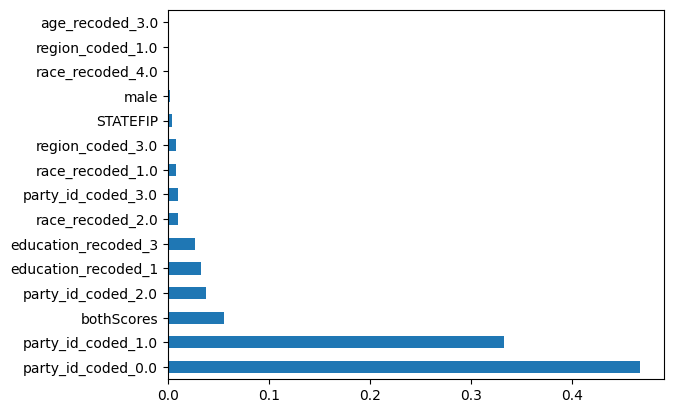

In [758]:
best_f1 = 0
for model in models:

    name = model[0]
    print(model[0])
    clf = model[1]
    params = model[2]

 
    # pipe = Pipeline(steps=[ ('model', clf)])
    
    grids =  GridSearchCV(clf, param_grid=params, scoring=['f1_weighted', 'neg_root_mean_squared_error'],cv=2, n_jobs=-1, refit='f1_weighted')
    grids.fit(X_train, y_train)
    y_preds = grids.best_estimator_.predict(X_test)
    if f1_score(y_test, y_preds, average='weighted') >= best_f1:
        new_model_2024 = grids.best_estimator_
        best_f1 = f1_score(y_test, y_preds, average='weighted')



    print('f1', f1_score(y_test, y_preds, average='weighted'))
print('best model', new_model_2024, 'model params', new_model_2024.get_params())
new_model_2024.fit(X_train, y_train)
y_preds = new_model_2024.predict(X_test)
y_preds = new_model_2024.predict_proba(X_test)
y_preds = [x[1] for x in y_preds]
X_test_copy = X_test.copy()
X_test_copy['predicted_vote'] = y_preds
X_test_copy['actual_vote'] = y_test
X_test_copy_filtered = X_test_copy[['male', 'STATEFIP', 'bothScores',
       'education_recoded_1', 'education_recoded_3', 'race_recoded_1.0',
       'race_recoded_2.0', 'race_recoded_4.0', 'race_recoded_9.0',
       'region_coded_1.0', 'region_coded_2.0', 'region_coded_3.0',
       'region_coded_4.0', 'age_recoded_1.0', 'age_recoded_2.0',
       'age_recoded_3.0', 'party_id_coded_0.0', 'party_id_coded_1.0',
       'party_id_coded_2.0', 'party_id_coded_3.0', 'party_id_coded_4.0']]

filtered_nat_df = nat_2024_to_pred.loc[X_test_copy_filtered.index]
filtered_nat_df['predicted_vote'] = X_test_copy['predicted_vote']
filtered_nat_df['actual_vote'] = X_test_copy['actual_vote']

df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'], )['predicted_vote'].value_counts().unstack(fill_value=0)

# probability version
df_final_pred2 = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].mean()

features=X_train.columns
importances = new_model_2024.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(new_model_2024.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')



In [730]:
X_test_copy_filtered = X_test_copy[['male', 'STATEFIP', 'bothScores',
       'education_recoded_1', 'education_recoded_3', 'race_recoded_1.0',
       'race_recoded_2.0', 'race_recoded_4.0', 'race_recoded_9.0',
       'region_coded_1.0', 'region_coded_2.0', 'region_coded_3.0',
       'region_coded_4.0', 'age_recoded_1.0', 'age_recoded_2.0',
       'age_recoded_3.0', 'party_id_coded_0.0', 'party_id_coded_1.0',
       'party_id_coded_2.0', 'party_id_coded_3.0', 'party_id_coded_4.0']]

filtered_nat_df = nat_2024_to_pred.loc[X_test_copy_filtered.index]
filtered_nat_df['predicted_vote'] = X_test_copy['predicted_vote']
filtered_nat_df['actual_vote'] = X_test_copy['actual_vote']

df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'], )['predicted_vote'].value_counts().unstack(fill_value=0)

# probability version
df_final_pred2 = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].mean()


/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12945/2006082946.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'], )['predicted_vote'].value_counts().unstack(fill_value=0)
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_12945/2006082946.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred2 = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_vote'].mean()


In [731]:
df_final_pred2
propensity_strat['ML_pred'] = propensity_strat['ML_pred'].fillna(propensity_strat['mrp_subgroup_estimate'])

age_recoded  race_recoded  male    education_recoded
1.0000       1.0000        0.0000  1                   0.6646
                                   3                   0.3189
                           1.0000  1                   0.7221
                                   3                   0.2695
             2.0000        0.0000  1                   0.0736
                                   3                      NaN
                           1.0000  1                   0.2683
                                   3                   0.0971
             4.0000        0.0000  1                   0.4649
                                   3                   0.1605
                           1.0000  1                   0.3133
                                   3                   0.0898
             9.0000        0.0000  1                   0.5190
                                   3                   0.2639
                           1.0000  1                   0.5503
                 

In [718]:
# all_genders = [True, False ]
# all_ages = [1,2, 3]
# all_educations = [1,3]
# all_races = [1,2, 3,4,9]
# all_combinations = pd.MultiIndex.from_product([all_ages,all_races, all_genders, all_educations], names=['age_recoded','race_recoded', 'male','education_recoded']).to_frame(index=False)
# preds_2024 = pd.merge(all_combinations,df_final_pred2, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
preds_2024 = df_final_pred2

In [797]:
new_mrp_2024 = pd.read_csv("../data/prop_scores_2024.csv")

In [799]:
new_mrp_2024.dropna(inplace = True)

In [801]:
new_mrp_2024['prop_pred'] = new_mrp_2024['mrp_subgroup_estimate']
new_mrp_2024.drop(columns = ['mrp_subgroup_estimate'], inplace = True)

In [803]:
new_census_by_state = pd.merge(census_by_state, new_mrp_2024, on = ['age_recoded', 'education_recoded', 'male', 'race_recoded', 'STATEFIP'], how='left')

In [859]:
new_census_by_state

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate_x,mrp_subgroup_estimate_se_x,PERWT,prop,STATE,...,2020_turnout,PERWT_state_scaled,PERWT_scaled_race,PERWT_scaled_age,bothScores,trump_votes_states,biden_votes_states,state_demo_ratio,mrp_subgroup_estimate_se_y,prop_pred
0,1,1,1,1,1,0.7247,0.0282,330345.0000,0.0013,AL,...,60.5000,199858.7250,189948.3750,181689.7500,0.6869,137281.0593,62577.6657,0.6869,0.0273,0.7019
1,1,1,1,1,2,0.7270,0.0311,58181.0000,0.0002,AK,...,63.8000,37119.4780,33454.0750,31999.5500,0.6887,25562.4311,11557.0469,0.6887,0.0306,0.7209
2,1,1,1,1,4,0.6596,0.0268,381824.0000,0.0015,AZ,...,71.9000,274531.4560,219548.8000,210003.2000,0.6381,175166.6886,99364.7674,0.6381,0.0262,0.6652
3,1,1,1,1,5,0.6943,0.0354,226141.0000,0.0009,AR,...,54.0000,122116.1400,130031.0750,124377.5500,0.6641,81100.6108,41015.5292,0.6641,0.0370,0.6779
4,1,1,1,1,6,0.5028,0.0243,1556291.0000,0.0061,CA,...,65.1000,1013145.4410,894867.3250,855960.0500,0.5205,527313.6308,485831.8102,0.5205,0.0256,0.4996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,3,9,0,3,51,0.3859,0.0402,564.0000,0.0000,VA,...,71.5000,403.2600,282.0000,411.7200,0.4176,168.3824,234.8776,0.4176,0.0426,0.3882
2991,3,9,0,3,53,0.2991,0.0343,512.0000,0.0000,WA,...,71.5000,366.0800,256.0000,373.7600,0.3524,129.0236,237.0564,0.3524,0.0350,0.3007
2992,3,9,0,3,54,0.4354,0.0447,111.0000,0.0000,WV,...,56.1000,62.2710,55.5000,81.0300,0.4547,28.3141,33.9569,0.4547,0.0425,0.4281
2993,3,9,0,3,55,0.3833,0.0381,258.0000,0.0000,WI,...,73.6000,189.8880,129.0000,188.3400,0.4157,78.9282,110.9598,0.4157,0.0382,0.3862


In [804]:
# pd.merge(census_by_state, preds_2024, on = ['age_recoded', 'education_recoded', 'male', 'race_recoded'], how='left')

In [879]:
# group by states and then predict if the state will go red or blue
# census_by_state_2024 = allStates.copy()
census_by_state_2024 = pd.merge(new_census_by_state, preds_2024, on = ['age_recoded', 'education_recoded', 'male', 'race_recoded'], how='left')
census_by_state_2024['predicted_vote'] = census_by_state_2024['predicted_vote'].fillna(census_by_state_2024['prop_pred'])
# census_by_state['bothScores'] = census_by_state['mrp_subgroup_estimate_x'] 
# census_by_state['bothScores'] = ((census_by_state['mrp_subgroup_estimate_x'] * 5 ) + census_by_state['ML_pred_mar'] + census_by_state['ML_pred_june'] + census_by_state['ML_pred_aug']) / 8
census_by_state_2024['bothScores_2024'] = ((census_by_state_2024['prop_pred'] *8 ) + census_by_state_2024['predicted_vote']) / 9
# census_by_state_2024['bothScores_2024'] = ((census_by_state_2024['prop_pred'] *7 ) + (census_by_state_2024['bothScores'])+ census_by_state_2024['predicted_vote'] ) / 9
# census_by_state_2024['bothScores_2024'] = ((census_by_state_2024['prop_pred']))

census_by_state_2024['trump_votes_states'] = census_by_state_2024['bothScores_2024'] * census_by_state_2024['PERWT_state_scaled']
census_by_state_2024['biden_votes_states'] = (1 - census_by_state_2024['bothScores_2024']) * census_by_state_2024['PERWT_state_scaled']
# sum up total trump/biden votes 

census_by_state_2024['state_demo_ratio'] =  census_by_state_2024['trump_votes_states'] / (census_by_state_2024['trump_votes_states'] + census_by_state_2024['biden_votes_states'] )
# census_by_state['mrp_and_ML'].value_counts()
elec_college_pred_2024 = census_by_state_2024.groupby('state')[['trump_votes_states','biden_votes_states'] ].sum()
# if trump votes > biden votes, then trump wins the state
elec_college_pred_2024['state_pred'] = elec_college_pred_2024.apply(lambda row: 1 if row['trump_votes_states'] > row['biden_votes_states'] else 0, axis = 1)
elec_college_pred_2024
final_pred_2024 = pd.merge(elec_college_pred_2024, elec_votes[:51], left_on = 'state', right_on = 'State')

print('trump sum', final_pred_2024['trump_votes_states'].sum(), 'biden sum', final_pred_2024['biden_votes_states'].sum())
final_pred_2024['state_votes'] = final_pred_2024['state_votes'].astype(int)
# sum up electoral votes for all states with pred of 1 and 0
final_pred_2024.groupby('state_pred')['state_votes'].sum()

trump sum 85789224.5342098 biden sum 83266784.57179022


state_pred
0    199
1    339
Name: state_votes, dtype: int64

In [881]:
final_pred_2024.to_csv("../data/final_pred_elec_2024.csv")

In [882]:
final_pred_2024

,trump_votes_states,biden_votes_states,state_pred,State,state_votes,biden,trump,harris,pence
0,1301509.3438,997704.8262,1,alabama,9,0,9,0,9
1,230295.0051,122779.9369,1,alaska,3,0,3,0,3
2,2321343.2174,1657855.8706,1,arizona,11,11,0,11,0
3,739623.2635,507296.1365,1,arkansas,6,0,6,0,6
4,7772597.5902,12013677.6738,0,california,55,55,0,55,0
5,1680517.2335,1311884.6465,1,colorado,9,9,0,9,0
6,867664.5330,1020678.5670,0,connecticut,7,7,0,7,0
7,242521.9569,274175.2751,0,delaware,3,3,0,3,0
8,98454.4326,385446.8874,0,district of columbia,3,3,0,3,0
9,5573030.5106,4985667.3034,1,florida,29,0,29,0,29
